In [1]:
from keras import backend as K

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, InputLayer
from keras.layers import BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

import sys

%matplotlib inline
print('done importing libraries')

done importing libraries


# New Section

In [3]:
train = pd.read_csv('/mnist_train.csv')
train = train.drop(['label'],axis=1).to_numpy().reshape(-1,28,28,1)


In [4]:
input_shape = (28,28,1)
final_encoder_dim = 2
decoder_input_dim = 4
depth = 5
kernel_size = 3
activation = 'tanh'
dropout = 0.1

In [5]:
def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images

dataset = tf.data.Dataset.from_tensor_slices({'image':train})
dataset = dataset.map(preprocess)
dataset = dataset.repeat(3).shuffle(100).batch(128).prefetch(1)

In [6]:
print(dataset)

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [7]:
def discriminator(input_shape, dim, depth, kernel, dropout,activation):
    layers = []
    layers.append(InputLayer(input_shape=input_shape))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel_size))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    layers.append(Flatten())
    layers.append(Dense(128,activation='relu'))
    layers.append(Dense(dim))
    return Sequential(layers)

encoder = discriminator(input_shape, final_encoder_dim, depth, kernel_size, dropout,activation)

In [8]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 26, 26, 16)        0         
                                                                 
 dropout (Dropout)           (None, 26, 26, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                        

In [9]:
def generator(input_shape, depth, output_shape,kernel,dropout):
    layers = []
    layers.append(InputLayer(input_shape=(input_shape,)))
    layers.append(Dense(784,activation='relu'))
    layers.append(Reshape(target_shape=output_shape))
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(BatchNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(dropout))
    
    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [28,28]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(1,kernel_size=1,activation=None))
    return Sequential(layers)
decoder = generator(decoder_input_dim, depth, input_shape,kernel_size,dropout)

In [10]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 784)               3920      
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 16)       160       
 nspose)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 30, 30, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 30, 30, 16)        0         
                                                                 
 dropout_4 (Dropout)         (None, 30, 30, 16)       

In [11]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
encoder_opt = tf.keras.optimizers.Adam()
decoder_opt = tf.keras.optimizers.Adam()

In [12]:
def training(training_data):
    batch_size = tf.shape(training_data)[0]
    real_data = training_data
    real_labels = tf.ones((batch_size,))
    fake_labels = tf.zeros((batch_size,))
    labels = tf.concat((real_labels,fake_labels),axis=0)
    noise = tf.random.normal((batch_size,decoder_input_dim),mean=0,stddev=1)
    
    with tf.GradientTape() as decoder_gt, tf.GradientTape() as encoder_gt:
        
        fake_images = decoder(noise,training=True)
        fake_labels_2 = encoder(fake_images,training=True)
        real_labels_2 = encoder(training_data,training=True)
        predicted_labels = tf.concat((real_labels_2,fake_labels_2),axis=0)
        

        discrim_loss = loss(labels,predicted_labels)
        #print(discrim_loss)
        gen_loss = loss(real_labels,fake_labels_2)
        
    dec_grad = decoder_gt.gradient(gen_loss,decoder.trainable_variables)
    enc_grad = encoder_gt.gradient(discrim_loss,encoder.trainable_variables)
    
    decoder_opt.apply_gradients(zip(dec_grad, decoder.trainable_variables))
    encoder_opt.apply_gradients(zip(enc_grad, encoder.trainable_variables))
    
    return discrim_loss, gen_loss

In [13]:
import os
def epoch_training(data_iterator, steps_per_epoch, avg_gen_loss, avg_dis_loss):
    for x in range(steps_per_epoch):
        d_loss, g_loss = training(next(data_iterator))
        avg_gen_loss.update_state(g_loss)
        avg_dis_loss.update_state(d_loss)
        if x%20==0:
            print('{} steps done'.format(x))
            
    gen_loss = avg_gen_loss.result()
    dis_loss = avg_dis_loss.result()
    
    
    tf.summary.scalar('gen_loss',gen_loss,step=encoder_opt.iterations)
    tf.summary.flush()
    tf.summary.scalar('dis_loss',dis_loss,step=decoder_opt.iterations)
    tf.summary.flush()
    
    avg_gen_loss.reset_state()
    avg_dis_loss.reset_state()
    return gen_loss.numpy(), dis_loss.numpy()
    
def train(training_data, epochs):
    checkpoint_dir = './training_checkpoints'
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(generator_optimizer=decoder_opt,discriminator_optimizer=encoder_opt,generator=decoder,discriminator=encoder)
    manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=5)
    checkpoint.restore(manager.latest_checkpoint)
    
    summary = tf.summary.create_file_writer('metrics/train')
    
    avg_generator_loss = tf.keras.metrics.Mean()
    avg_discriminator_loss = tf.keras.metrics.Mean()
    
    data_iterator = training_data.__iter__()
    for i in range(epochs):
        with summary.as_default():
            gen_loss, dis_loss = epoch_training(data_iterator, 100, avg_generator_loss, avg_discriminator_loss)
            print({'gen_loss':gen_loss,'dis_loss':dis_loss})
            manager.save()

In [14]:
train(dataset,3)

0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 4.8910866, 'dis_loss': 0.48871216}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 7.997656, 'dis_loss': 0.10266032}
0 steps done
20 steps done
40 steps done
60 steps done
80 steps done
{'gen_loss': 9.29969, 'dis_loss': 0.01766696}


TypeError: ignored

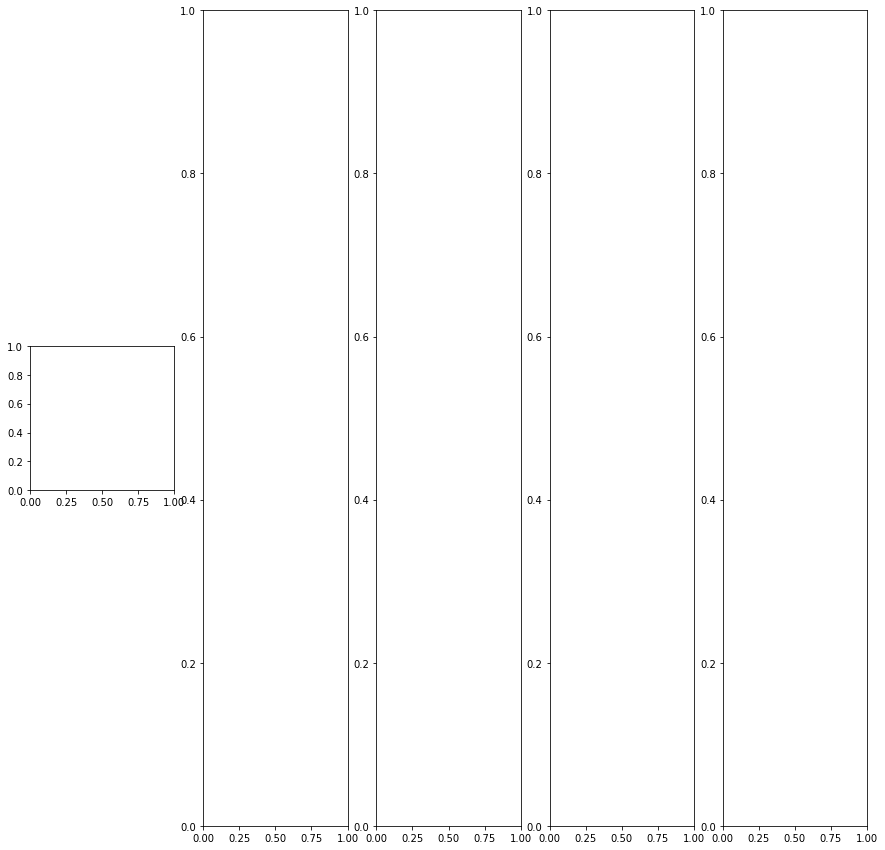

In [ ]:
noise = tf.random.normal((5,4),mean=0,stddev=1)
images = decoder(noise,training=False)
fig,axes = plt.subplots(1,5,figsize=(15,15))
for index,x in enumerate(images):
    axes[index].imshow(x)

TypeError: ignored

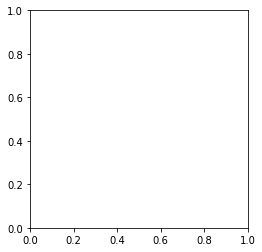

In [ ]:
count =0
for x in dataset:
    
    plt.imshow(x[1])
    if count==5:
        break
    count+=1

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint